In [20]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import IPython.html.widgets as widgets
from IPython.html.widgets import interactive
from IPython.display import display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


<h1 style="text-decoration: underline, overline; color: navy;">Rapport de stage</h1>

<h2 style="text-decoration: underline;">Partie I : Robot controlé par DNF</h2>

Pour arriver à ce résulat deux outils ont été utilisés :
* vrep : simulateur de robot
* DNFPY : le logiciel codant des DNF en python par Benoit

Il a fallu donc faire le lien entre ces deux logiciels.

###La classe VRepSimulator

Issue d'une classe abstraite RobotSimulator elle même issue de la classe Map2D de DNFPY, cette classe a pour but de servir d'interface entre DNFPY et vrep.

Elle permet d'initialiser une map simulator donc les diverses fonctions sont :
* connection : permet la connexion avec Vrep et le lancement de la simulation
* disconnection : met fin à la connexion et à la simulation
* compute : fait un pas d'itération dans le cas du mode synchrone
* getSensor : récupère les données d'un capteur
* getSensors : récupère les données de plusieurs capteurs
* setController : permet de modifier l'ordre d'un controleur

Voici les diverses commandes associées à Vrep que l'on retrouve dans les fonctions précédentes :

* Connexion et déconnexion :

clientID=vrep.simxStart('127.0.0.1',port,True,True,5000,5)
vrep.simxFinish(clientID)

* Mode synchrone :

vrep.simxSynchronous(clientID,True) #active le mode synchrone
vrep.simxSynchronousTrigger(clientID) #permet de rajouter un pas

* Simulation :

vrep.simxStartSimulation(clientID,vrep.simx_opmode_oneshot_wait)
vrep.simxStopSimulation(clientID,vrep.simx_opmode_oneshot_wait)

* Permet d'obtenir un handle :
    
errorCode,sensor_handle=vrep.simxGetObjectHandle(clientID,'ePuck_proxSensor1',vrep.simx_opmode_oneshot_wait)


* Appel d'un capteur de proximité :

errorCode,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(clientID,sensor_handle,vrep.simx_opmode_streaming)


* Changer la valeur des moteurs :

errorCode=vrep.simxSetJointTargetVelocity(clientID,left_motor_handle,vl, vrep.simx_opmode_streaming)

###La classe GetIRSensors

Hérite de MapND, elle a comme enfant la map VRepSimulator et en récupère les données des capteurs de proximité infrarouge ePuck dans une liste.

L'organisation des maps est créé dans la classe ModelEPuckDNF.

###La classeMotorProjection

Hérite de Map2D, c'est la racine double (pour chaque roue) des maps. 
Elle a comme enfant les maps VRepSimulator et Activation obtenu par une map DNF qui a elle même comme enfant GetIRSensors.

Le gros du travail est effectué ici. Si jamais il y a une quelconque activation entre $-\frac{\Pi}{2}$ et $\frac{\Pi}{2}$ alors la vitesse des roues va être modifiées selon la loi suivante pour la roue gauche :
$\frac{3}{1+e^{(x*5)}}-1.5$
<p>Et symétriquement dans le cas de la roue droite.</p>

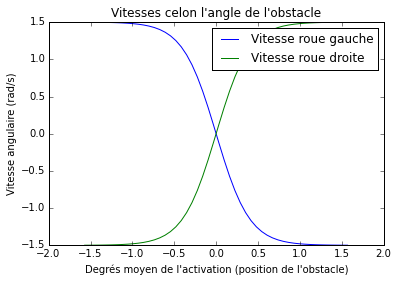

In [9]:
x, st = np.linspace(-math.pi/2,math.pi/2, retstep=True)
vL = 3/(1+np.exp(x*5))-1.5
vR = 3/(1+np.exp(-x*5))-1.5
plt.plot(x,vL,label='Vitesse roue gauche')
plt.plot(x,vR,label='Vitesse roue droite')
plt.legend()
plt.xlabel("Degrés moyen de l'activation (position de l'obstacle)")
plt.ylabel("Vitesse angulaire (rad/s)")
plt.title("Vitesses celon l'angle de l'obstacle")
plt.show()

Mais l'activation n'étant pas une valeur mais une courbe, il faut d'abord en tirer une valeur intéressante et situé entre $-\frac{\Pi}{2}$ et $\frac{\Pi}{2}$. Pour cela, nous avons fait la moyenne pondérée des angles par le poids de l'activation.
C'est à dire $\frac{\sum{\phi_i V_i}}{\sum{V_i}}$ avec $\phi_i$ les angles de chaques capteur et $V_i$ l'activation i.

Pour vérifier le bon fonctionnement dynamique de la formule face à un obstacle, observons $\frac{d\phi}{dt} = \omega$ en fonction de $\psi$.

Nous connaissons la taille de l'axe des deux roues ($\Delta = 52 mm$) et le rayon des roues ($r = 20.5 mm$).
On en déduit que face à un obstacle $\omega =\frac{r}{\Delta}(v_d-v_g)= \frac{2r}{\Delta}v_d$ avec $v_d = -v_g$ la vitesse angulaire du moteur droit.

Et hors de l'obstacle $\omega = 0rad/s$ car les deux roues vont à la même vitesse

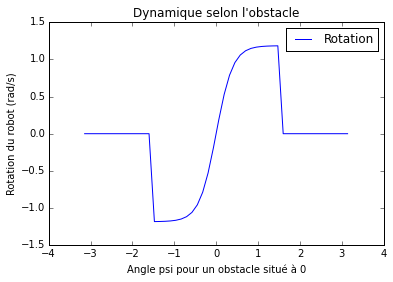

In [19]:
x=np.linspace(-math.pi,math.pi)
vR = 3/(1+np.exp(-x*5))-1.5
for i in range(50):
    if x[i]<-math.pi/2 or x[i]>math.pi/2:
        vR[i]=0
r=20.5
delta=52
w=2*r/delta*vR
plt.plot(x,w, label='Rotation')
plt.legend()
plt.xlabel("Angle psi pour un obstacle situé à 0")
plt.ylabel("Rotation du robot (rad/s)")
plt.title("Dynamique selon l'obstacle")
plt.show()